In [13]:
from segment_everything.detect_and_segment import segment_from_stacked_labels
from segment_everything.prompt_generator import YoloDetector
from segment_everything.weights_helper import get_weights_path
from segment_everything.stacked_labels import StackedLabels
from segment_everything.detect_and_segment import segment_from_stacked_labels
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import random_label_cmap

In [8]:
conf = 0.5
iou = 0.8
imagesz = 1024
descriptor = "MobileSAM Model"
boxes = True

yolo_detecter = YoloDetector(str(get_weights_path("ObjectAwareModel")), "ObjectAwareModelFromMobileSamV2", device='cuda')
        

In [9]:
from skimage.io import imread

image_name = r'C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\ladybugs_series\26638467_41374651.jpg'
img = imread(image_name)

In [10]:
results = yolo_detecter.get_results(img, conf=conf, iou= iou, imgsz=imagesz, max_det=10000)
bbs=results[0].boxes.xyxy.cpu().numpy()
stacked_labels = StackedLabels.from_yolo_results(bbs, None, img)
segmented_stacked_labels = segment_from_stacked_labels(stacked_labels, "MobileSamV2")
segmented_stacked_labels.sort_largest_to_smallest()
labels = segmented_stacked_labels.make_2d_labels(type="min")
        


0: 1024x960 39 objects, 47.9ms
Speed: 6.0ms preprocess, 47.9ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)


VIT checkpoint loaded successfully


In [21]:
import numpy as np
import colorsys


def hsv_to_rgb(arr):
    hsv_to_rgb_channels = np.vectorize(colorsys.hsv_to_rgb)
    h, s, v = np.rollaxis(arr, axis=-1)
    r, g, b = hsv_to_rgb_channels(h, s, v)
    rgb = np.stack((r, g, b), axis=-1)
    return rgb


def mask_overlay(img, masks, colors=None):
    """Overlay masks on image (set image to grayscale).

    Args:
        img (int or float, 2D or 3D array): Image of size [Ly x Lx (x nchan)].
        masks (int, 2D array): Masks where 0=NO masks; 1,2,...=mask labels.
        colors (int, 2D array, optional): Size [nmasks x 3], each entry is a color in 0-255 range.

    Returns:
        RGB (uint8, 3D array): Array of masks overlaid on grayscale image.
    """
    if colors is not None:
        if colors.max() > 1:
            colors = np.float32(colors)
            colors /= 255
        colors = utils.rgb_to_hsv(colors)
    if img.ndim > 2:
        img = img.astype(np.float32).mean(axis=-1)
    else:
        img = img.astype(np.float32)

    HSV = np.zeros((img.shape[0], img.shape[1], 3), np.float32)
    HSV[:, :, 2] = np.clip((img / 255. if img.max() > 1 else img) * 1.5, 0, 1)
    hues = np.linspace(0, 1, masks.max() + 1)[np.random.permutation(masks.max())]
    for n in range(int(masks.max())):
        ipix = (masks == n + 1).nonzero()
        if colors is None:
            HSV[ipix[0], ipix[1], 0] = hues[n]
        else:
            HSV[ipix[0], ipix[1], 0] = colors[n, 0]
        HSV[ipix[0], ipix[1], 1] = 1.0
    RGB = (hsv_to_rgb(HSV) * 255).astype(np.uint8)
    return RGB

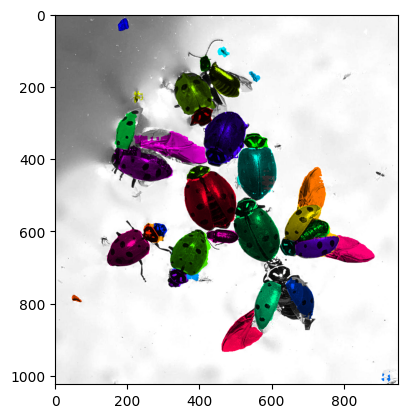

In [23]:
test = mask_overlay(img, labels)

plt.imshow(test, cmap=random_label_cmap())

In [11]:
import napari
from  napari_segment_everything import segment_everything

viewer = napari.Viewer()
segment_everything_widget=segment_everything.NapariSegmentEverything(viewer)
viewer.window.add_dock_widget(segment_everything_widget)
segment_everything_widget.load_project(segmented_stacked_labels.image, segmented_stacked_labels.mask_list)


area 192.0 27982.0
label_num 1 39
solidity 0.32764505119453924 0.9727636181909045
circularity 0.19237908137929463 0.8234817265690586
mean_intensity 25.31562302340291 197.359375
10th_percentile_intensity 4.0 184.1
mean_hue 20.537680290775494 75.34663411191669
mean_saturation 85.16564983216925 217.41005184234092
predicted_iou 0.5472383499145508 0.980248212814331
stability_score 0.6202531456947327 0.9825803637504578
